## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

__NB:__ `conda install -c r rpy2=2.8.6 -f`
rpy2 needs to be a specific version to work in the ipython notebook.

This is the code to do the abc in R, it's useful for debugging.
```
%%R -i PRIOR,prior_args
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[prior_args]), PRIOR[,7], nval=2, tols=c(.5), method="rejection")
print(summary(cv.res.reg))
#plot(cv.res.reg)
print(cv.res.reg)
```

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

import os
GIMME_DIR = "/home/isaac/gimmeSAD/"
os.chdir(GIMME_DIR)

import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyparallel as ipp
import itertools
import random
import glob
import scipy
import rpy2.interactive as r
import rpy2.interactive.packages
import datetime
import time

from ipyrad.assemble.util import progressbar 
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import linregress

GIMME_DIR = "/home/isaac/gimmeSAD/"
os.chdir(GIMME_DIR)
ONED_DIR = GIMME_DIR + "1d_sims/"
TWOD_DIR = GIMME_DIR + "2d_sims/"

## Set up the link to ipcluster and create a loadbalanced view
## Need to run this externally, and wait for a little bit.
## `ipcluster start -n 40 --cluster-id gimmeCV
ipyclient = ipp.Client(cluster_id="gimmeCV")
print(len(ipyclient), 'cores')
thview = ipyclient.load_balanced_view()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
(40, 'cores')


In [5]:
## A function to return RMSE and R
def get_stats(tr, est):
    tr = np.array(tr).flatten()

    rms = sqrt(mean_squared_error(tr, est))
    r = np.corrcoef(np.vstack((tr, est)))[1,0]

    return rms, r

In [6]:
def call_abc(REF_TABLE, model, param, model_args, NCV=10):
    import pandas as pd
    import rpy2.interactive as r
    import rpy2.interactive.packages
    from rpy2 import robjects
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()

    r.packages.importr("abc")
    abc = r.packages.packages.abc

    ## Read in the prior
    ## Return the prior as a huge df
    PRIOR = pd.read_csv(REF_TABLE, sep="\t")

    cvresults = abc.cv4abc(PRIOR[param], PRIOR[model_args[model]], nval=NCV, tols=robjects.r["c"](0.01, 0.05), method="rejection")
    ## results_dict[model][param] = cvresults
    return cvresults


## Gather all the simulations into one huge simout file

In [7]:
## Three options
##  ONEPER          - Randomly select only one line per file (one sample from the
##                    entire temporal history of the community).
##  REGULARIZE      - Normalize all pi/dxy bins so they are proportional and not counts.
##                    This normalization routine makes loading the file much slower.
##  DROPEQUILIBSIMS - Remove all the extra simulations at equilibrium because it fucks up the prior.
def gather_simouts(SIMOUT_DIR, oneper=True, regularize=False, subset=False):
    ONEPER = oneper
    REGULARIZE = regularize
    DROPEQUILIBSIMS = True
    ## For making a small dataset for testing so it doesn't take forever
    SUBSET = subset

    filename = "priors.txt"
    if REGULARIZE:
        filename = "normed_priors.txt"
    REF_TABLE = os.path.join(SIMOUT_DIR, filename)
    outfile = open(REF_TABLE, "w")


    files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
    numsims = 0
    outfile.write(open(files[0]).readlines()[0])

    for f in files:
        lines = open(f).readlines()[1:]
        new_lines = []
        try:
            for line in lines:
                if line.split()[3] == "1" and DROPEQUILIBSIMS:
                    pass
                else:
                    new_lines.append(line)
        except:
            print("Error in file {}".format(f))
        ## Only choose one step per simulation?
        if lines and ONEPER:
            try:
                new_lines = [random.choice(new_lines)]
                new_lines = [x.strip() + "\n" for x in new_lines]
            except:
                ## Sometimes you get a file that's all sims at eq, so this is blank
                continue

        ## DO or don't regularlize the histograms
        if REGULARIZE:
            tmp_lines = []
            for line in new_lines:
                try:
                    hist = np.array([int(x) for x in line.split()[7:]])
                    if np.sum(hist):
                        tot = np.sum(hist)
                        hist = hist/float(tot)
                    tmp = line.split()[:7] + map(str,hist)
                    line = "\t".join(tmp) + "\n"
                    if "NaN" in line:
                        ## Sometimes something screws up so just drop it
                        continue
                    else:
                        tmp_lines.append(line)
                except:
                    continue
            new_lines = tmp_lines
        ## Don't write blanks
        if new_lines:
            numsims += len(new_lines)
            outfile.write("".join(new_lines))
        if SUBSET:
            if numsims > 20000:
                break
    outfile.close()
    print("Processed {} simulations.".format(numsims))
    return REF_TABLE

ONED_PRIOR_INTS = gather_simouts(ONED_DIR, oneper=True, regularize=False, subset=False)
TWOD_PRIOR_INTS = gather_simouts(TWOD_DIR, oneper=True, regularize=False, subset=False)
ONED_PRIOR_NORMED = gather_simouts(ONED_DIR, oneper=True, regularize=True, subset=False)
TWOD_PRIOR_NORMED = gather_simouts(TWOD_DIR, oneper=True, regularize=True, subset=False)


Processed 14402 simulations.
Processed 14400 simulations.
Processed 14402 simulations.
Processed 14400 simulations.


## Walk through and perform CV for each parameter using each data configuration.
## Parallelized with ipcluster so it's much faster

In [8]:
## For the impatient, do them all at once forking w/ ipcluster
DO_NORMED = False
if DO_NORMED:
    ONED_PRIOR = ONED_PRIOR_NORMED
    TWOD_PRIOR = TWOD_PRIOR_NORMED
else:
    ONED_PRIOR = ONED_PRIOR_INTS
    TWOD_PRIOR = TWOD_PRIOR_INTS
    
models = ["Ma", "Mi", "Mai", "Mmi", "Mami"]
model_args = {"Ma":["shannon"],\
              "Mi":["bin_"+str(x) for x in range(0,10)],\
              "Mai":["shannon"] + ["bin_"+str(x) for x in range(0,10)],\
              "Mmi":["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)],\
              "Mami":["shannon"] + ["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)]}
params = ["K", "c", "%equil", "colrate", "extrate", "shannon"]

## Create the dict for holding results
cv_jobs = {}
alljobs = []
for model in models:
    
    ## Select the right prior for each model
    if "m" in model:
        PRIOR = TWOD_PRIOR
    else:
        PRIOR = ONED_PRIOR

    cv_jobs[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        ## print("Doing {} {}".format(model, param))
        cv_jobs[model][param] = thview.apply(call_abc, *[PRIOR, model, param, model_args, 100])
        alljobs.append(cv_jobs[model][param])

## Wait for all jobs to finish
start = time.time()
while 1:
    total = len(alljobs)
    ready = [i.ready() for i in alljobs]
    printstr = ' waiting   | {} |'
    elapsed = datetime.timedelta(seconds=int(time.time()-start))
    progressbar(total, sum(ready), printstr.format(elapsed))
    time.sleep(0.1)
    if all(ready):
        break
print("done")

Skipping H' estimation for model - Ma
Skipping H' estimation for model - Mai
Skipping H' estimation for model - Mami
  [####################] 100%  waiting   | 0:09:08 | done


## Pull results out of the asyncs

### Which ones took the longest? Out of curiosity

In [9]:
## get results for each model/param combination
results_dict = {}
for model in models:
    results_dict[model] = {}
    for param in params:
        try:
            results_dict[model][param] = cv_jobs[model][param].result()
            print("{}\t{}\t{}\t{}".format(cv_jobs[model][param].elapsed, model, param, type(results_dict[model][param])))
        except Exception as inst:
            print("{} {} {}".format(model, param, inst))

28.44034	Ma	K	<class 'rpy2.robjects.vectors.ListVector'>
29.750973	Ma	c	<class 'rpy2.robjects.vectors.ListVector'>
31.639767	Ma	%equil	<class 'rpy2.robjects.vectors.ListVector'>
28.602762	Ma	colrate	<class 'rpy2.robjects.vectors.ListVector'>
35.279198	Ma	extrate	<class 'rpy2.robjects.vectors.ListVector'>
Ma shannon 'shannon'
131.953651	Mi	K	<class 'rpy2.robjects.vectors.ListVector'>
124.031002	Mi	c	<class 'rpy2.robjects.vectors.ListVector'>
128.322833	Mi	%equil	<class 'rpy2.robjects.vectors.ListVector'>
136.009594	Mi	colrate	<class 'rpy2.robjects.vectors.ListVector'>
131.722548	Mi	extrate	<class 'rpy2.robjects.vectors.ListVector'>
132.030218	Mi	shannon	<class 'rpy2.robjects.vectors.ListVector'>
138.849965	Mai	K	<class 'rpy2.robjects.vectors.ListVector'>
138.695742	Mai	c	<class 'rpy2.robjects.vectors.ListVector'>
140.473577	Mai	%equil	<class 'rpy2.robjects.vectors.ListVector'>
140.725536	Mai	colrate	<class 'rpy2.robjects.vectors.ListVector'>
136.733815	Mai	extrate	<class 'rpy2.robjects.

## Do a bunch of nasty rpy2 stuff to get the data out

In [10]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

cv_dict = {}
for model in models:
    cv_dict[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        cv_dict[model][param] = {}
        cvresults = results_dict[model][param]
        df_true = pandas2ri.ri2py(cvresults[cvresults.names.index('true')])
        df_est = pandas2ri.ri2py(cvresults[cvresults.names.index('estim')])
        #df_est = pandas2ri.ri2py(cvresults[cvresults.names.index('')])
        tru = np.array(df_true).flatten()
        est = np.array(df_est).flatten()[:100]
        cv_dict[model][param]["true"] = tru
        cv_dict[model][param]["estim"] = est
        rms, r = get_stats(tru, est)
        cv_dict[model][param]["rms"] = rms
        cv_dict[model][param]["r"] = r


Skipping H' estimation for model - Ma
Skipping H' estimation for model - Mai
Skipping H' estimation for model - Mami


In [11]:
## Print the rms and r2 for each model x param

print("Model\tParam\tRMS\t\tR")
for model in models:
    for param in params:
        try:
            rms = cv_dict[model][param]["rms"]
            r2 = cv_dict[model][param]["r"]**2
            rms = format(rms, ".3f")
            r2 = format(r2, ".3f")
            print("{}\t{}\t{}\t{}".format(model, param, rms, r2))
        except:
            pass
    print("")

Model	Param	RMS		R
Ma	K	2017.611	0.481
Ma	c	0.015	0.003
Ma	%equil	0.176	0.577
Ma	colrate	0.014	0.009
Ma	extrate	0.003	0.327

Mi	K	1073.387	0.855
Mi	c	0.005	0.872
Mi	%equil	0.161	0.590
Mi	colrate	0.005	0.858
Mi	extrate	0.002	0.812
Mi	shannon	0.222	0.875

Mai	K	1177.680	0.797
Mai	c	0.005	0.880
Mai	%equil	0.138	0.754
Mai	colrate	0.006	0.832
Mai	extrate	0.002	0.800

Mmi	K	1320.739	0.771
Mmi	c	0.006	0.869
Mmi	%equil	0.230	0.382
Mmi	colrate	0.005	0.908
Mmi	extrate	0.002	0.704
Mmi	shannon	0.323	0.758

Mami	K	1148.946	0.815
Mami	c	0.005	0.914
Mami	%equil	0.184	0.692
Mami	colrate	0.006	0.831
Mami	extrate	0.002	0.776



## Define function to make the fancy plot

In [12]:
pretty_params = {"K":"K", "c":"c", "%equil":u"Λ", "colrate":"c'", "extrate":u"†", "shannon":"H'"}
pretty_models = {"Ma":"$\mathregular{M_a}$", "Mi":"$\mathregular{M_i}$", "Mai":"$\mathregular{M_{ai}}$",\
                "Mmi":"$\mathregular{M_{mi}}$", "Mami":"$\mathregular{M_{ami}}$"}

import matplotlib
matplotlib.rc('text', usetex = False)


def plot_cv(model, cv_dict):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300)
    axarr = [a for b in axarr for a in b]
    
    for param, ax in zip(params, axarr):
        pname = pretty_params[param]
        if "a" in model and param == "shannon":
            continue
        print(model, param),

        x = cv_dict[model][param]["true"]
        y = cv_dict[model][param]["estim"]
        
        xmin = ymin = min(x)
        xlim = ylim = max(x)
        
        ## linregress gets the rvalue and polyfit/poly1d gives us the fit function so we can draw the regression line
        res = linregress(x,y)
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)

        ## Calculate RMSE
        err=scipy.sqrt(sum((x-y)**2)/float(len(x)))
        RMSE = "RMSE {0:.4f}".format(cv_dict[model][param]["rms"])
        R2 = "R^2  {0:.4f}".format(cv_dict[model][param]["r"]**2)
        print(RMSE, R2)

        ## Plot the data and the regression line
        ax.scatter(x, y, marker=".", color='w', edgecolors='black', s=10)
        pts = np.linspace(xmin, xlim)
        ax.plot(pts, fit_fn(pts), '-r')

        ## Set titles and x/y limits
        ax.set_xlabel(u"True {}".format(pname), fontsize=12)
        ax.set_ylabel(u"Estimated {}".format(pname), fontsize=12)
        
        ## Don't add plot titles cuz they're obvious
        #ax.set_title(RUN_NAME, fontsize=10)

        ## Plot the identity line
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        plt.gca().set_facecolor('white')
        ax.grid(False)

        ## Add RMSE and R^2 to plots
        #ax.text(0.2, 0.9, RMSE, ha='center', va='center', transform=ax.transAxes, color='r', size=8)
        #ax.text(0.2, 0.78, R2, ha='center', va='center', transform=ax.transAxes, color='r', size=8)

        ## Remove the stupid tick spines
        ax.tick_params(axis=u'both', which=u'both',length=0)

    ## Give a little space between plots
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    #plt.tight_layout()
    plt.suptitle(pretty_models[model], fontsize=13)
    plt.savefig("/home/isaac/gimmeSAD/ABC-CV-{}.svg".format(model))

('Ma', 'K') ('RMSE 2017.6106', 'R^2  0.4811')
('Ma', 'c') ('RMSE 0.0147', 'R^2  0.0027')
('Ma', '%equil') ('RMSE 0.1762', 'R^2  0.5766')
('Ma', 'colrate') ('RMSE 0.0143', 'R^2  0.0088')
('Ma', 'extrate') ('RMSE 0.0034', 'R^2  0.3267')

('Mi', 'K') ('RMSE 1073.3866', 'R^2  0.8547')
('Mi', 'c') ('RMSE 0.0051', 'R^2  0.8718')
('Mi', '%equil') ('RMSE 0.1614', 'R^2  0.5896')
('Mi', 'colrate') ('RMSE 0.0055', 'R^2  0.8579')
('Mi', 'extrate') ('RMSE 0.0025', 'R^2  0.8116')
('Mi', 'shannon') ('RMSE 0.2221', 'R^2  0.8749')

('Mai', 'K') ('RMSE 1177.6802', 'R^2  0.7969')
('Mai', 'c') ('RMSE 0.0049', 'R^2  0.8804')
('Mai', '%equil') ('RMSE 0.1381', 'R^2  0.7542')
('Mai', 'colrate') ('RMSE 0.0058', 'R^2  0.8324')
('Mai', 'extrate') ('RMSE 0.0024', 'R^2  0.7999')

('Mmi', 'K') ('RMSE 1320.7387', 'R^2  0.7711')
('Mmi', 'c') ('RMSE 0.0055', 'R^2  0.8688')
('Mmi', '%equil') ('RMSE 0.2297', 'R^2  0.3816')
('Mmi', 'colrate') ('RMSE 0.0051', 'R^2  0.9078')
('Mmi', 'extrate') ('RMSE 0.0019', 'R^2  0.7038'

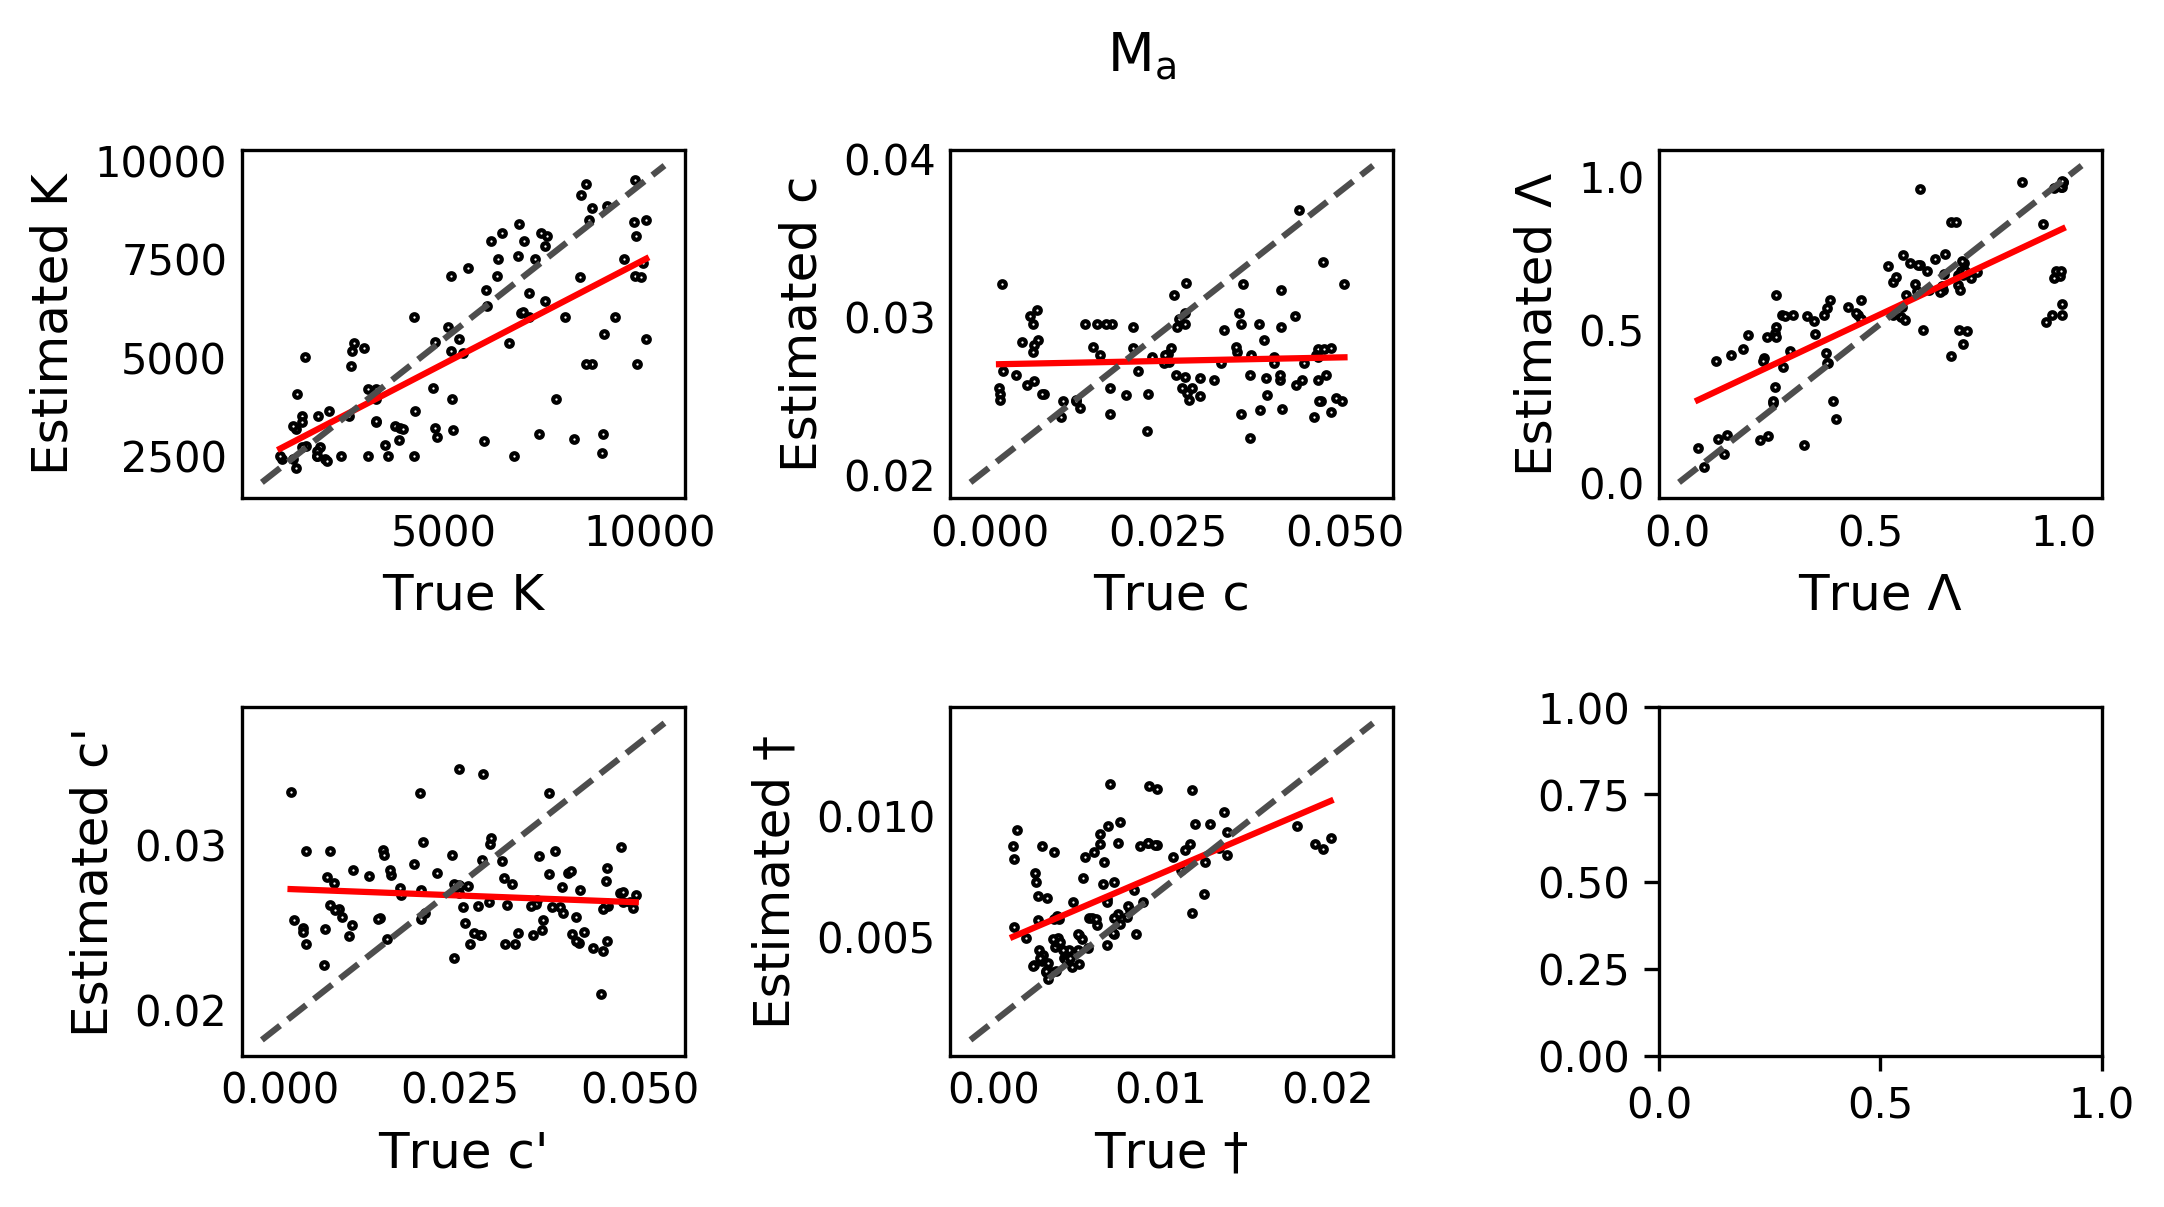

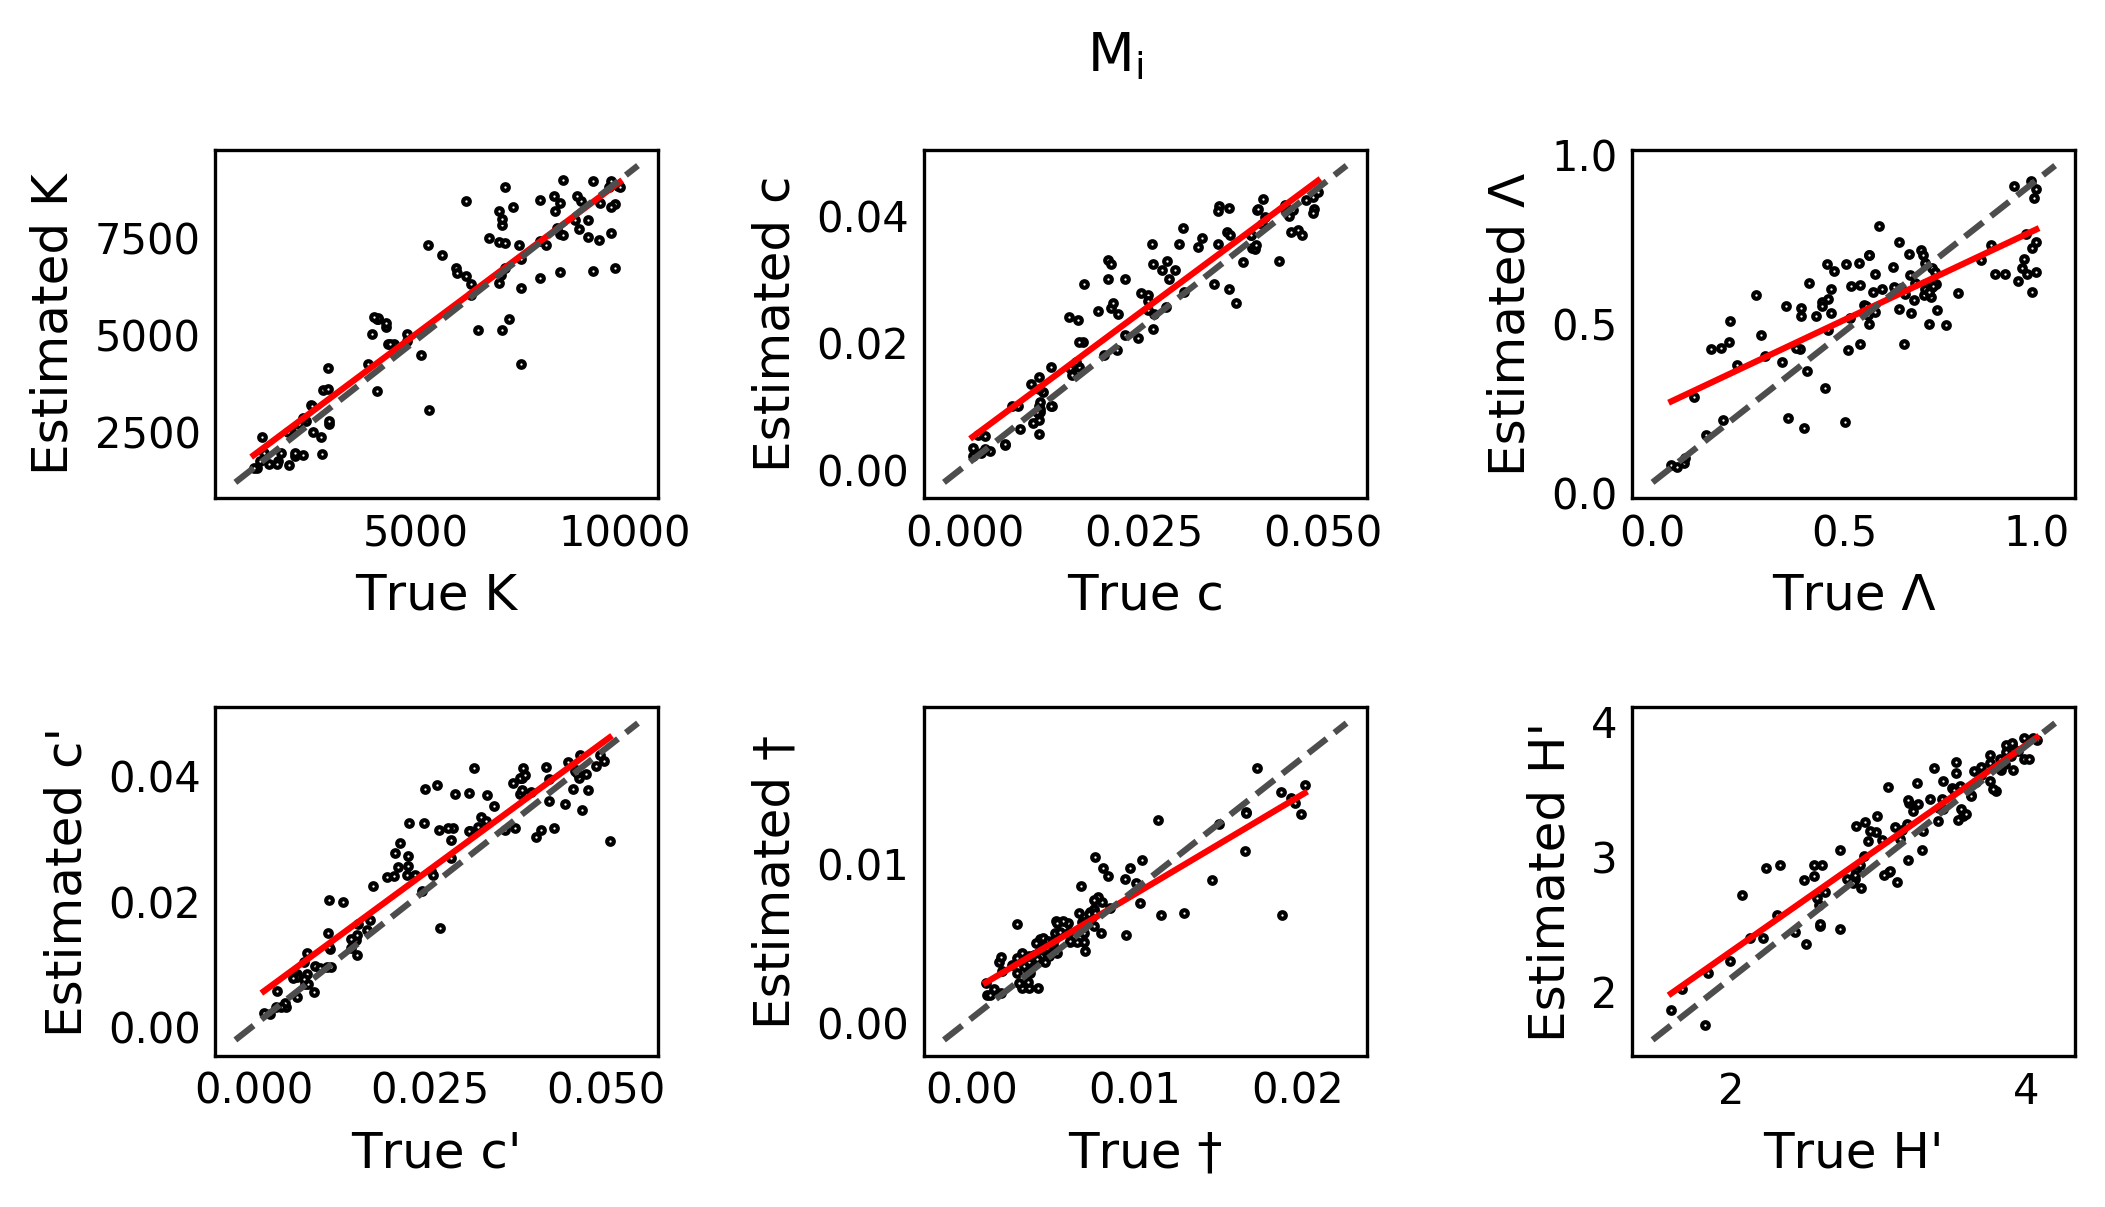

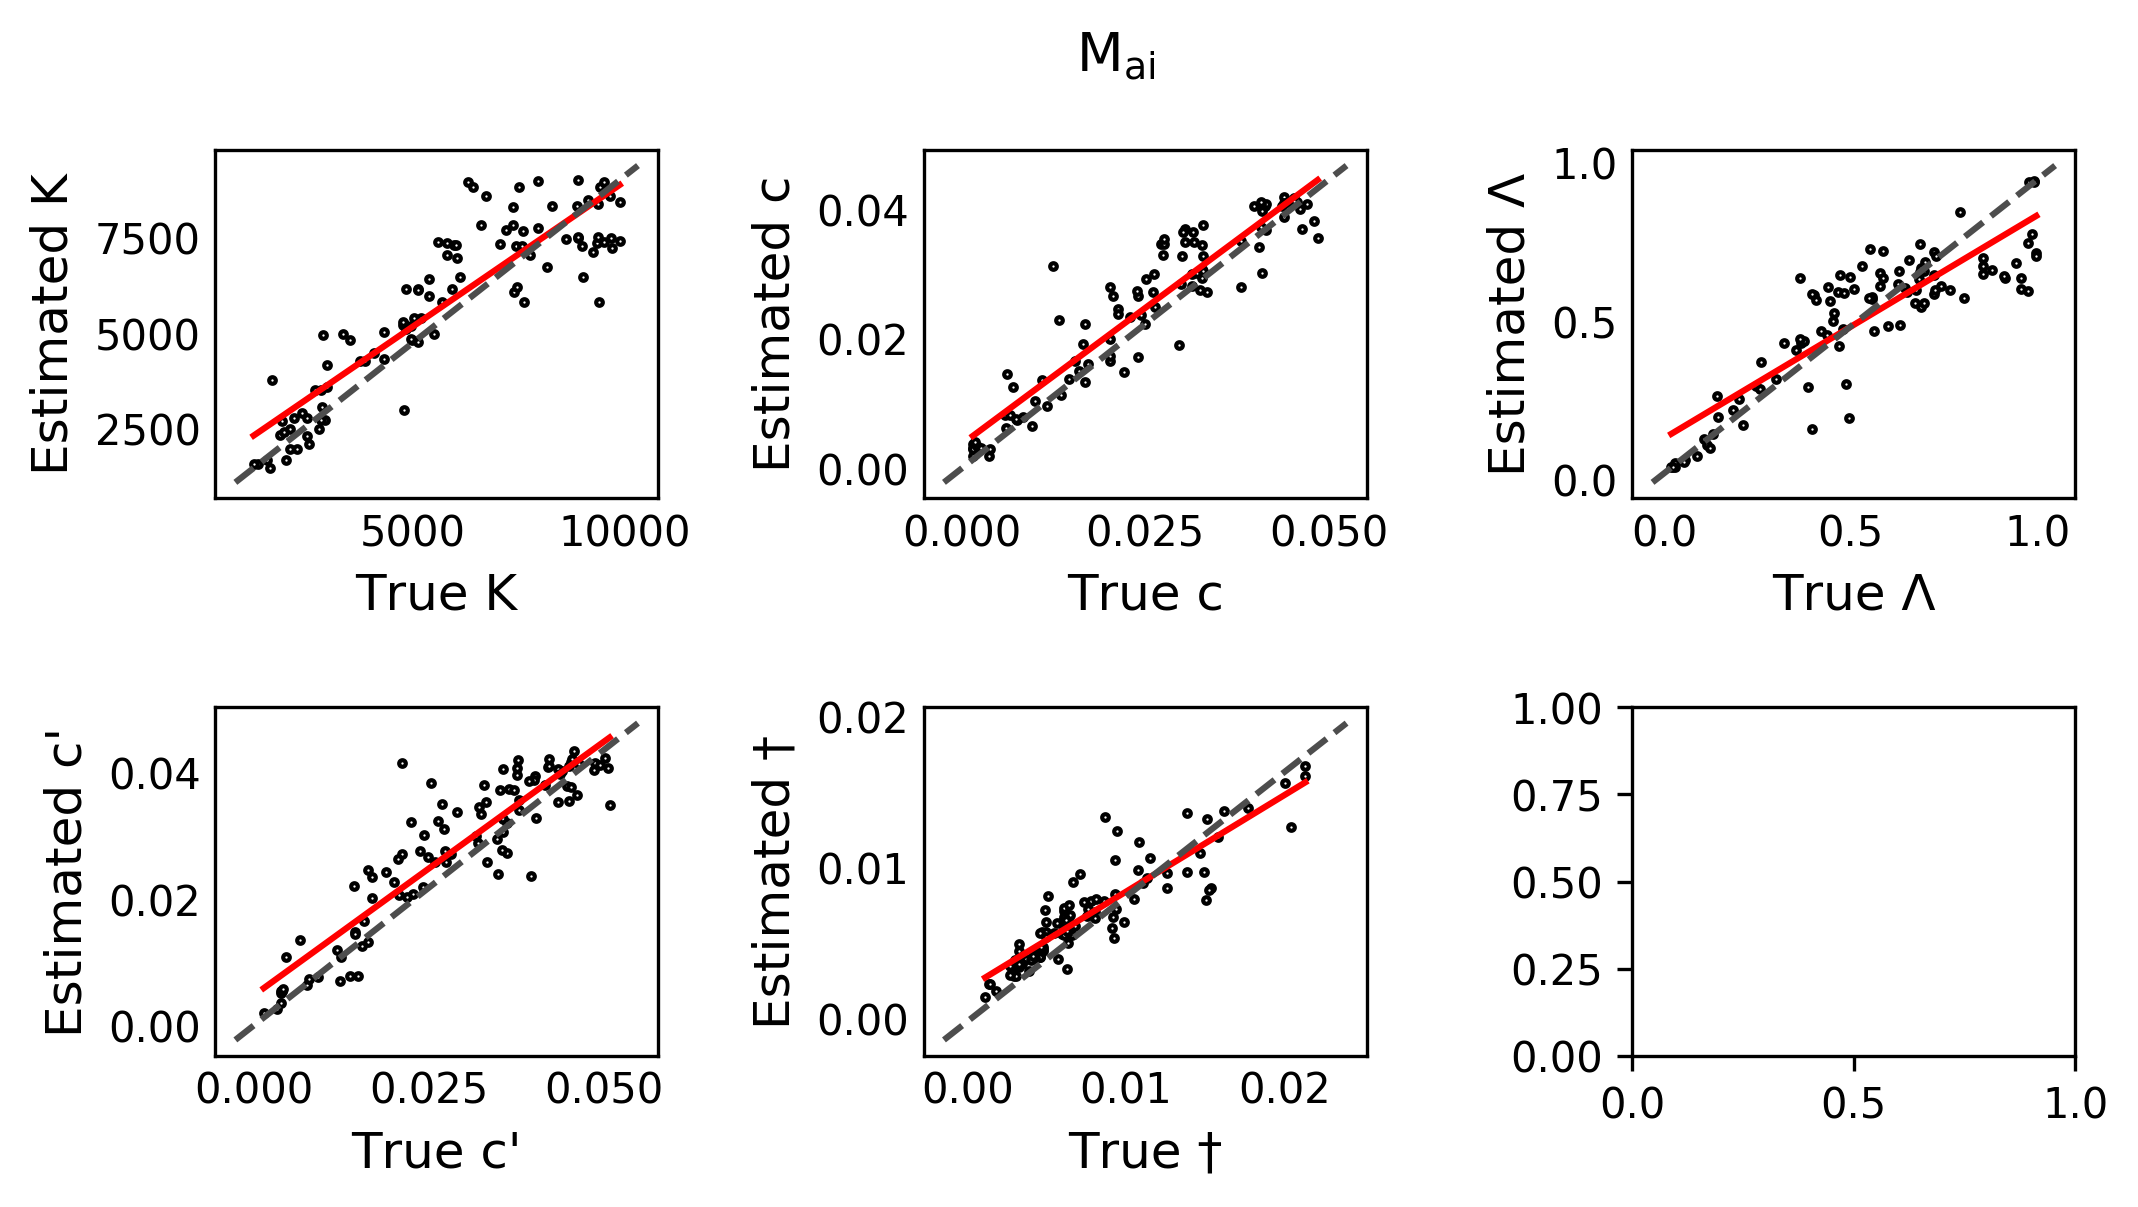

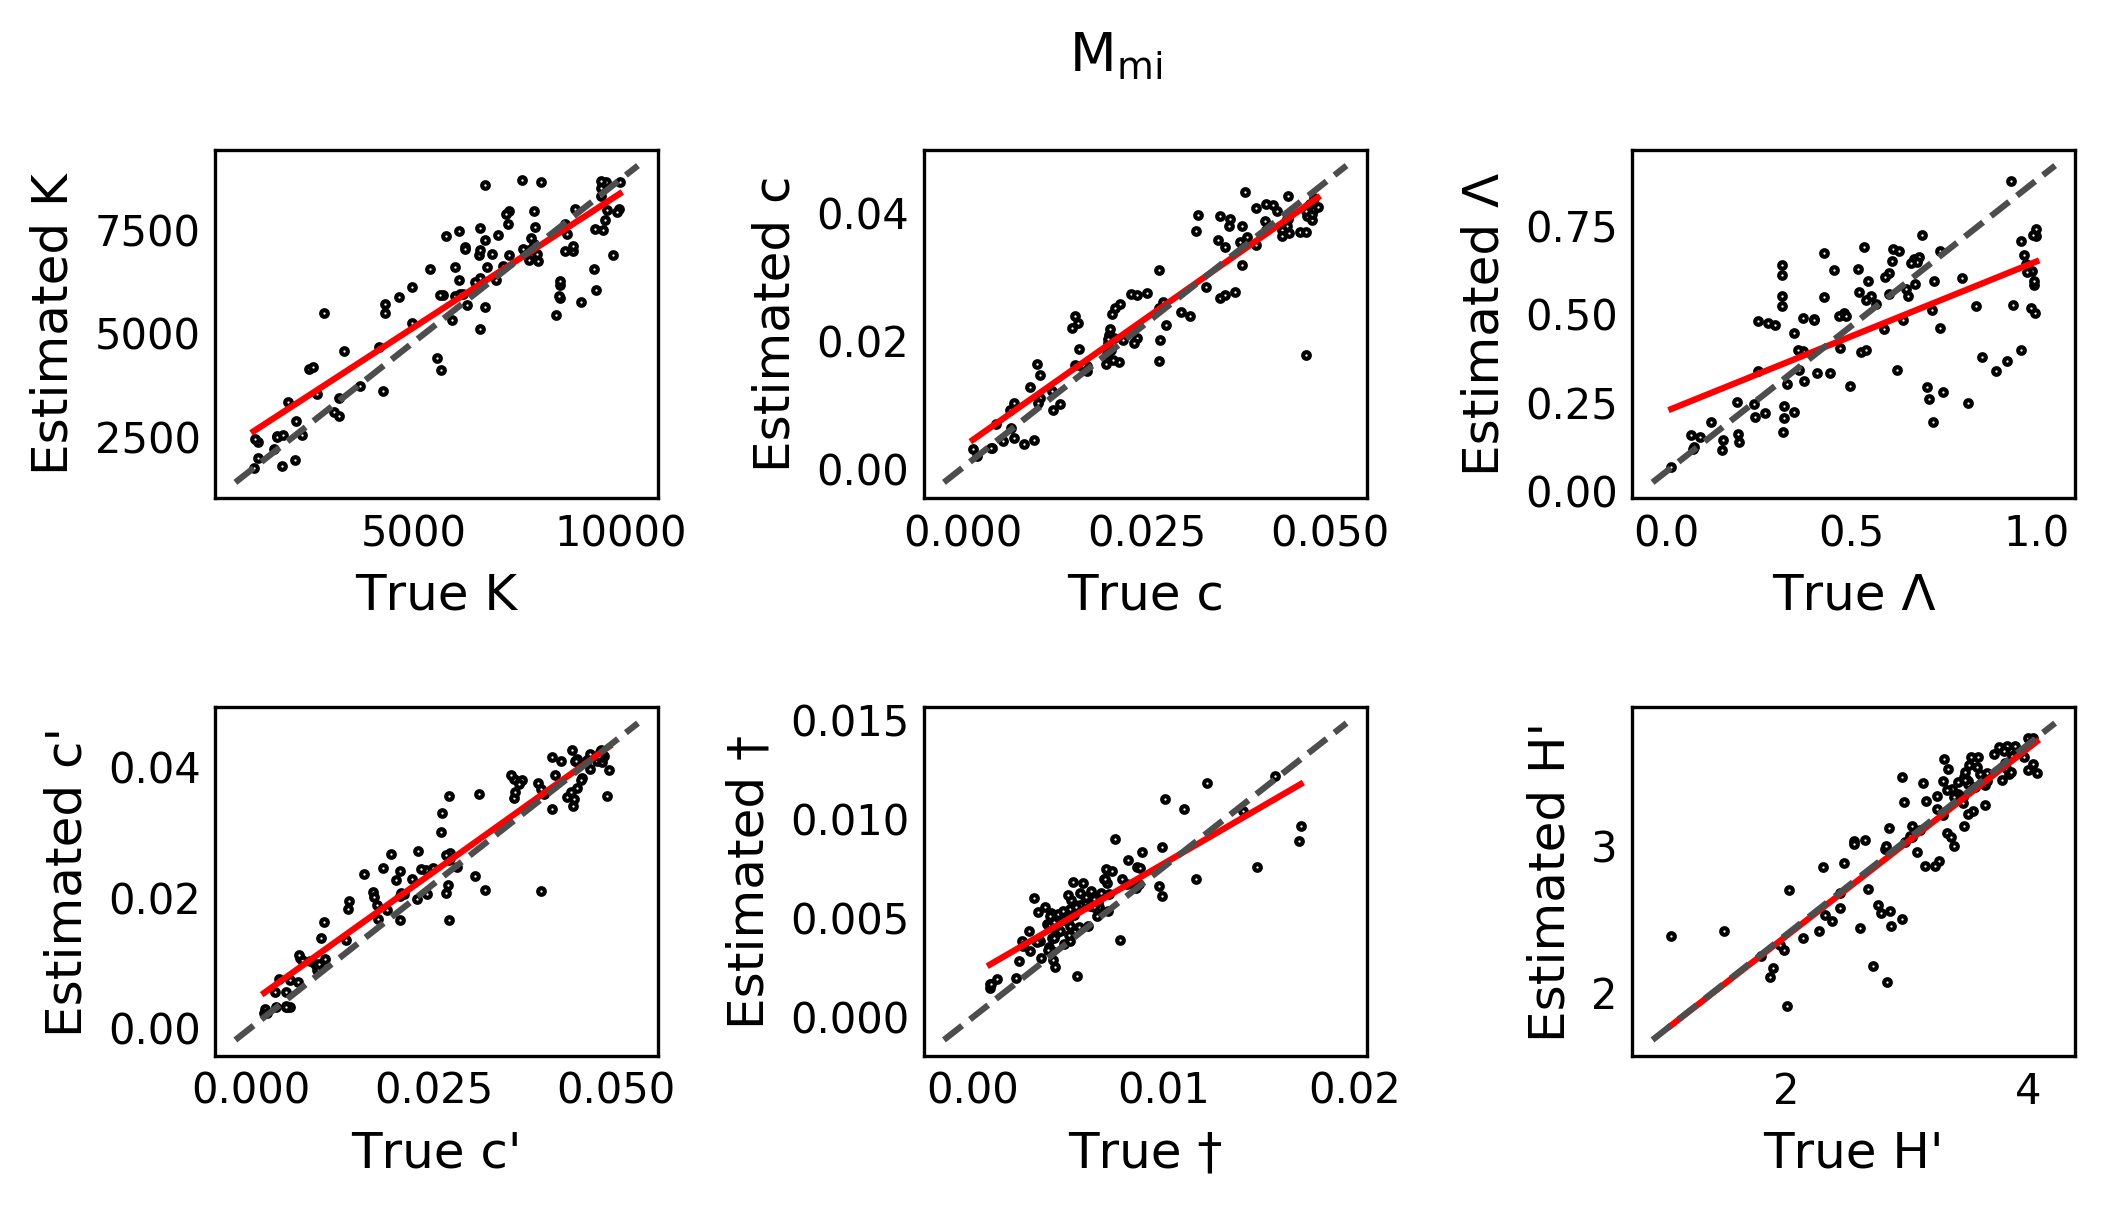

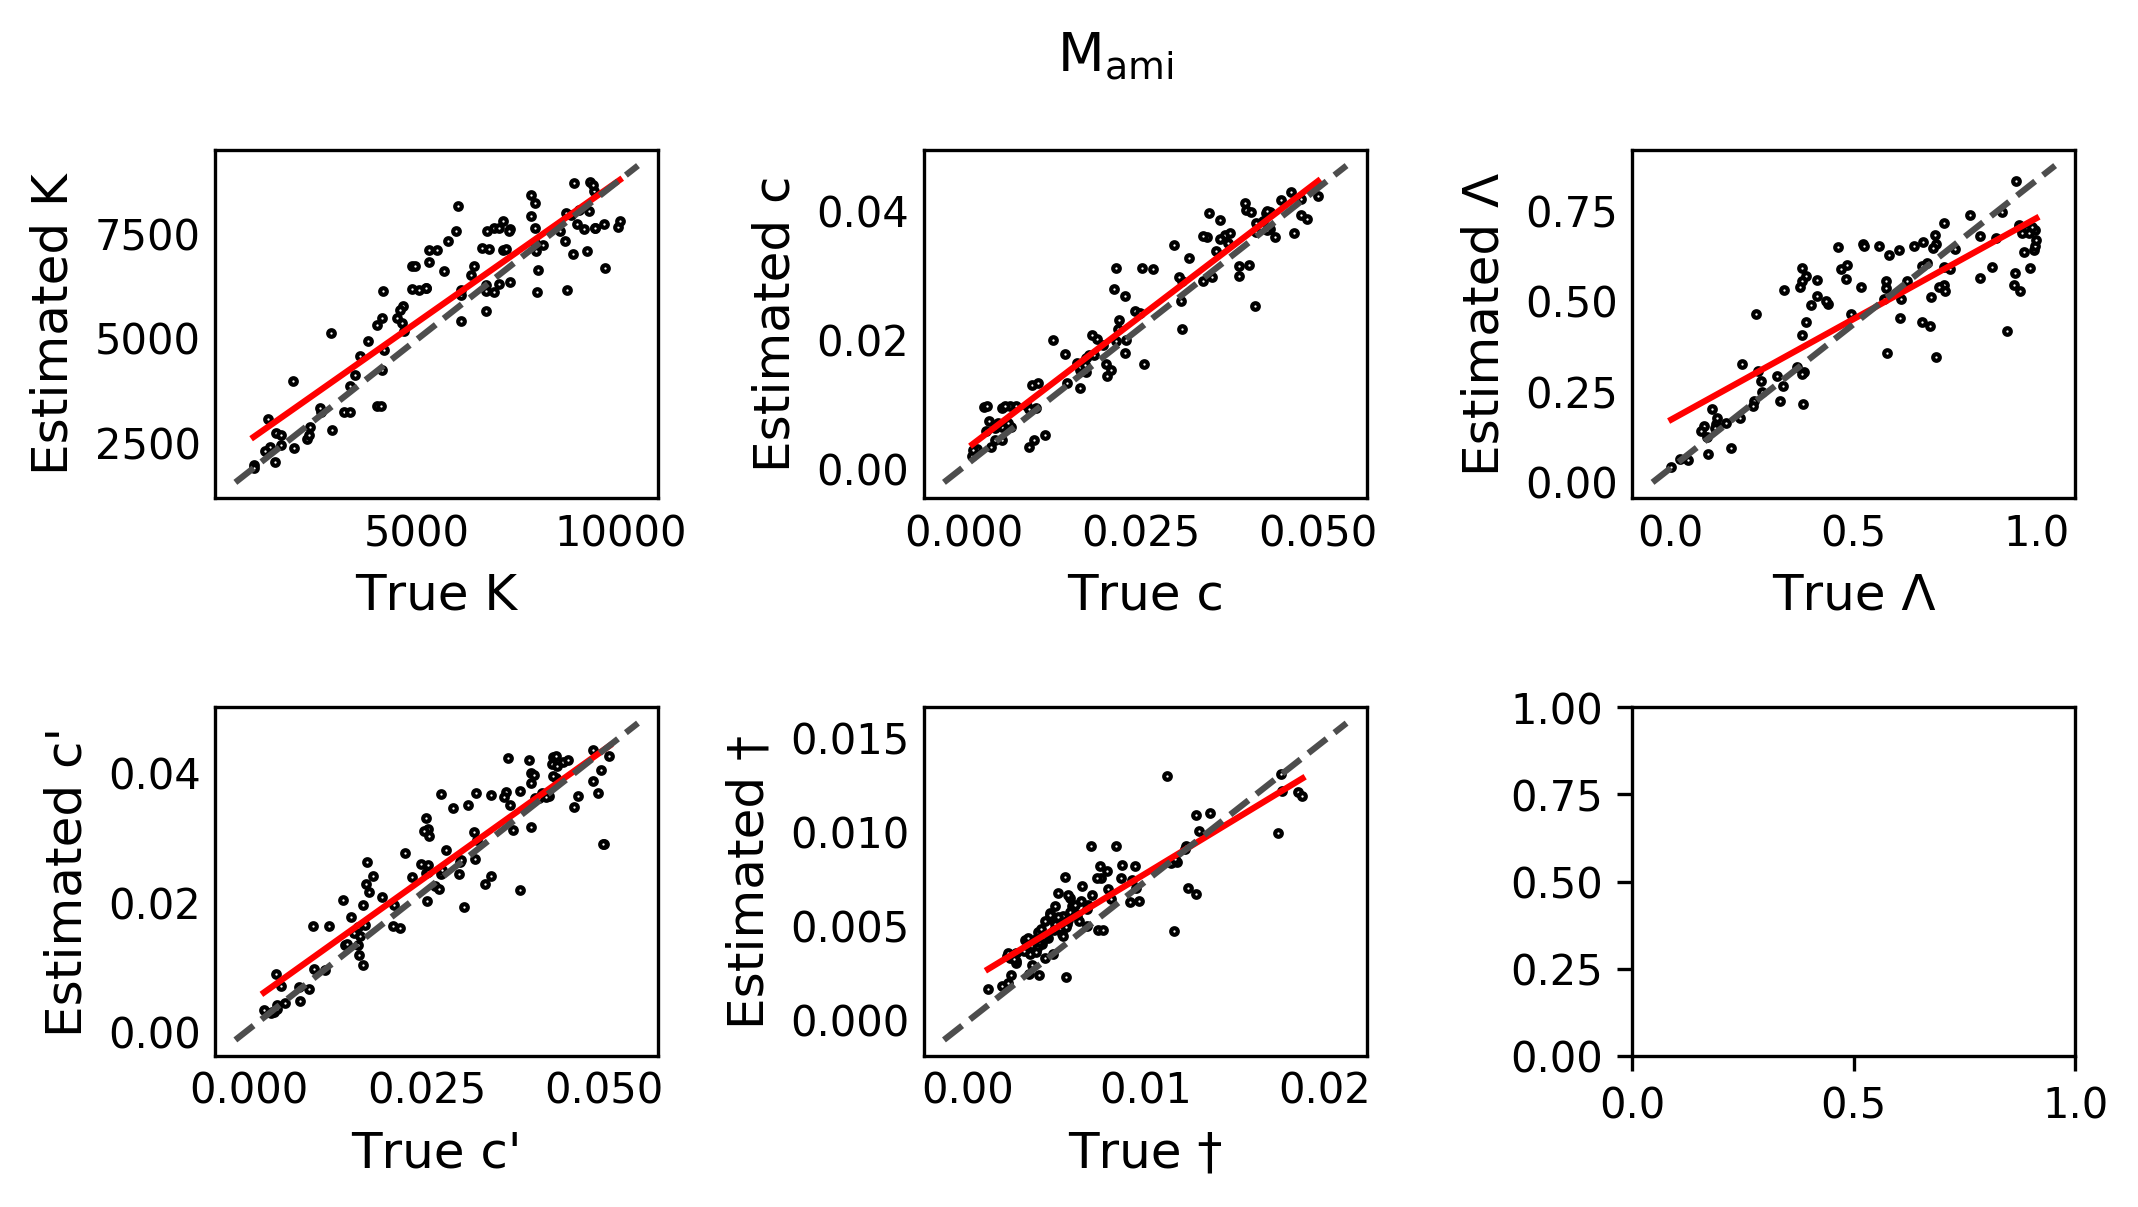

In [13]:
## Useful matplotlib style gallery
## https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
## https://matplotlib.org/examples/style_sheets/style_sheets_reference.html
import matplotlib.style as style
for model in models:
#for model in ["Ma"]:
    plot_cv(model, cv_dict)
    print("")

## Everything below here is crap

In [78]:
type(results_dict["Mai"]["c"])

pandas.core.frame.DataFrame

# Scenario M(I) - 1D SGD
## Estimate H' using 1D π vector

## Estimate Λ using 1D π pi vector

# Scenario M(MI) - 2D SGD

# Debugging ABC with NaN in the reference table due to 
# screwed up normalization. FUcKKKKkkK!

In [505]:
PRIOR = pd.read_csv("/home/isaac/gimmeSAD/2d_sims/priors.txt", sep="\t")[:2000]
print(len(PRIOR))
prior_args = model_args["Mami"][0:68]
print(prior_args)
cvresults = abc.cv4abc(PRIOR["c"], PRIOR[prior_args], nval=2, tols=robjects.r["c"](0.5), method="loclinear")
print(cvresults)

2000
['shannon', 'bin_0_0', 'bin_0_1', 'bin_0_2', 'bin_0_3', 'bin_0_4', 'bin_0_5', 'bin_0_6', 'bin_0_7', 'bin_0_8', 'bin_0_9', 'bin_1_0', 'bin_1_1', 'bin_1_2', 'bin_1_3', 'bin_1_4', 'bin_1_5', 'bin_1_6', 'bin_1_7', 'bin_1_8', 'bin_1_9', 'bin_2_0', 'bin_2_1', 'bin_2_2', 'bin_2_3', 'bin_2_4', 'bin_2_5', 'bin_2_6', 'bin_2_7', 'bin_2_8', 'bin_2_9', 'bin_3_0', 'bin_3_1', 'bin_3_2', 'bin_3_3', 'bin_3_4', 'bin_3_5', 'bin_3_6', 'bin_3_7', 'bin_3_8', 'bin_3_9', 'bin_4_0', 'bin_4_1', 'bin_4_2', 'bin_4_3', 'bin_4_4', 'bin_4_5', 'bin_4_6', 'bin_4_7', 'bin_4_8', 'bin_4_9', 'bin_5_0', 'bin_5_1', 'bin_5_2', 'bin_5_3', 'bin_5_4', 'bin_5_5', 'bin_5_6', 'bin_5_7', 'bin_5_8', 'bin_5_9', 'bin_6_0', 'bin_6_1', 'bin_6_2', 'bin_6_3', 'bin_6_4', 'bin_6_5', 'bin_6_6']
$calls
$calls$tol0.5
abc(target = target, param = param, sumstat = sumstat, tol = 0.5, 
    subset = subset, method = "loclinear", hcorr = TRUE, transf = "none", 
    logit.bounds = c(0, 0), kernel = NULL)


$cvsamples
[1]  994 1870

$tols
[1] 0.

In [506]:
%%R -i PRIOR,prior_args
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[prior_args]), PRIOR[,7], nval=2, tols=c(.5), method="rejection")
print(summary(cv.res.reg))
#plot(cv.res.reg)
#print(cv.res.reg)


Prediction error based on a cross-validation sample of 2

    eq.shannon eq.bin_0_0 eq.bin_0_1 eq.bin_0_2 eq.bin_0_3 eq.bin_0_4
0.5  0.1710794  0.3125000                                            
    eq.bin_0_5 eq.bin_0_6 eq.bin_0_7 eq.bin_0_8 eq.bin_0_9 eq.bin_1_0
0.5                                                         0.2699704
    eq.bin_1_1 eq.bin_1_2 eq.bin_1_3 eq.bin_1_4 eq.bin_1_5 eq.bin_1_6
0.5  0.1448137  0.2500000                                            
    eq.bin_1_7 eq.bin_1_8 eq.bin_1_9 eq.bin_2_0 eq.bin_2_1 eq.bin_2_2
0.5                                   0.5000000  0.5918367  1.0000000
    eq.bin_2_3 eq.bin_2_4 eq.bin_2_5 eq.bin_2_6 eq.bin_2_7 eq.bin_2_8
0.5        Inf                                                       
    eq.bin_2_9 eq.bin_3_0 eq.bin_3_1 eq.bin_3_2 eq.bin_3_3 eq.bin_3_4
0.5                                              1.0000000  1.0000000
    eq.bin_3_5 eq.bin_3_6 eq.bin_3_7 eq.bin_3_8 eq.bin_3_9 eq.bin_4_0
0.5                             

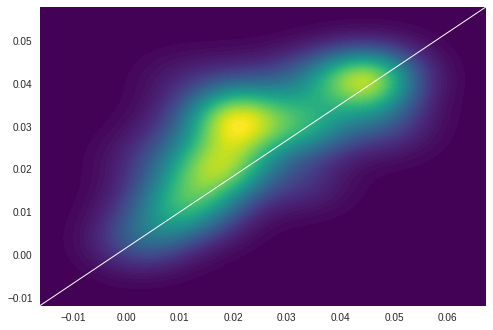

In [548]:
import seaborn as sns
x = cv_dict[model]["c"]["true"]
y = cv_dict[model]["c"]["estim"]

# cubehelix
ax = sns.kdeplot(x, y, n_levels=100, shade=True, shade_lowest=True, cmap="viridis")
ax.set_facecolor("black")
ax.grid(False)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="white", linewidth=1)

In [8]:
ipyclient = ipp.Client()
print(len(ipyclient), 'cores')

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


IOError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.